In [21]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import glob, os
from glob import glob
import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#pip install torchsummary
from torchsummary import summary

In [22]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


In [23]:
data_dir = ''

In [24]:
# Verification of the number of Images 

# load filenames for human and dog images
size = 0
size = np.array(glob(data_dir+"images/*"))

# Check one image
#Image.open(open("/kaggle/input/plant-pathology-2020-fgvc7/images/Train_3.jpg", 'rb'))

# print number of images in each dataset
print('There are %d total images.' % len(size))

sample_csv = pd.read_csv(data_dir + 'sample_submission.csv')
test_csv = pd.read_csv(data_dir + 'test.csv')
train_csv = pd.read_csv(data_dir + 'train.csv')

train_csv

There are 3642 total images.


,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


In [25]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, id_col, target_col, root_dir, sufix=None, transform=None):
        """
        Args:
            csv_file   (string):             Path to the csv file with annotations.
            root_dir   (string):             Directory with all the images.
            id_col     (string):             csv id column name.
            target_col (string):             csv target column name.
            sufix      (string, optional):   Optional sufix for samples.
            transform  (callable, optional): Optional transform to be applied on a sample.
        """
        self.data      = pd.read_csv(csv_file)
        self.id        = id_col
        self.target    = target_col
        self.root      = root_dir
        self.sufix     = sufix
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get the image name at the different idx
        img_name = self.data.loc[idx, self.id]
        
        # if there is not sufic, nothing happened. in this case sufix is '.jpg'
        if self.sufix is not None:
            img_name = img_name + self.sufix
        
        # it opens the image of the img_name at the specific idx
        image = Image.open(os.path.join(self.root, img_name))
        
        # if there is not transform nothing happens, here we defined below two transforms for train and for test
        if self.transform is not None:
            image = self.transform(image)
        
        # define the label based on the idx
        label = self.data.iloc[idx, 1:5].values.astype('int64')
        label = np.argwhere(label ==1)
        label = label.item(0)
        label = torch.tensor(label)
        
        return image, label
    
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}
'''
need to add albumentations as A
data_transforms = {
    'train': transforms.Compose([
        A.Resize(256),
        A.RandomHorizontalFlip(),
        A.Rotate(20),
        A.Flip(),
        A.Transpose(),
        A.Normaliza(p=1.0)
        A.RandomResizedCrop(height=512, width=512, p=1.0),
        A.ToTensorV2(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}
'''

params = {
    'id_col':     'image_id',  
    'target_col': ['healthy', 'multiple_diseases', 'rust', 'scab'],
    'sufix':      '.jpg',
    'transform':  data_transforms['train']
}

train_dataset = CustomDataset(csv_file=data_dir+'train.csv', root_dir=data_dir+'images', **params)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [26]:


print('TRAINING')
img, lab = train_dataset.__getitem__(0)

print('DATASET')
print('image at the first row: ', img.shape)
print('image size at the first row: {}'.format(img.size()))
print('Lab at the first row: ', lab)
print('lab format at the first row: {}'.format(lab))
print('lab format at the first row: {}'.format(lab.shape))


print()
print('Train Loader type')
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = train_iter.next()
print()
print('DATALOADER')
print('images type on batch size = {}'.format(type(images)))
print('images shape on batch size = ', images.shape)
print('labels type on batch size = {}'.format(type(labels)))
print('labels shape on batch size = ', labels.shape)



TRAINING
DATASET
image at the first row:  torch.Size([3, 224, 224])
image size at the first row: torch.Size([3, 224, 224])
Lab at the first row:  tensor(3)
lab format at the first row: 3
lab format at the first row: torch.Size([])

Train Loader type
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>

DATALOADER
images type on batch size = <class 'torch.Tensor'>
images shape on batch size =  torch.Size([32, 3, 224, 224])
labels type on batch size = <class 'torch.Tensor'>
labels shape on batch size =  torch.Size([32])


In [27]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # CL sees 224 x 224 x 3 image tensor
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv11= nn.Conv2d(16, 16, 2, padding=0)
        self.conv1_1 = nn.Conv2d(16, 32, 3, padding=1)
        
        # CL sees 112 x 112 x 16
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv22 = nn.Conv2d(64, 64, 2, padding=0)
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        
        
        # CL sees 56 x 56 x 32
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv33 = nn.Conv2d(256, 256, 2, padding=0)
        self.conv3_1 = nn.Conv2d(256, 512, 3, padding=1)
        
        
        # CL sees 28 x 28 x 64
        self.conv4 = nn.Conv2d(512, 1024, 3, padding=1)
        self.conv44 = nn.Conv2d(1024, 1024, 2, padding=0)
        self.conv4_1 = nn.Conv2d(1024, 2048, 3, padding=1)
        
        #batchNorm
        self.batchnorm16 = nn.BatchNorm2d(16)
        self.batchnorm32 = nn.BatchNorm2d(32)
        self.batchnorm64 = nn.BatchNorm2d(64)
        self.batchnorm128 = nn.BatchNorm2d(128)
        self.batchnorm256 = nn.BatchNorm2d(256)
        self.batchnorm512 = nn.BatchNorm2d(512)
        self.batchnorm1024 = nn.BatchNorm2d(1024)
        self.batchnorm2048 = nn.BatchNorm2d(2048)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(3, 3)
        self.AVGpool = nn.AvgPool2d(3, 3)
        
        # h1 linear layer (64 * 28 * 28 -> 500)
        self.fc1 = nn.Linear(2048 * 2 * 2, 500)
        
        # h2 linear layer (500 -> 250)
        self.fc2 = nn.Linear(500, 250)
        
        # h3 linear layer (250 -> 125)
        self.fc3 = nn.Linear(250, 125)
        
        # h4 linear layer (125 -> 4)
        self.fc4 = nn.Linear(125, 4)
        
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout2d(0.2)
        
        # LogSoftmax
        self.LogSM = nn.LogSoftmax()
    
    def forward(self, x):
        ## Define forward behavior
        # 1st CNN
        # 3 => 16
        x = self.conv1(x)
        x = F.relu6(x)
        x = self.conv11(x)
        x = F.relu6(x)
        x = self.batchnorm16(x)
        
        # 16 => 32
        x = self.conv1_1(x)
        x = F.relu6(x)
        x = self.batchnorm32(x)
        
        x = self.AVGpool(x)
        x = self.dropout(x)
        
        # 2nd CNN
        # 32 => 64
        x = self.conv2(x)
        x = F.relu6(x)
        x = self.conv22(x)
        x = F.relu6(x)
        x = self.batchnorm64(x)
        
        # 64 => 128
        x = self.conv2_1(x)
        x = F.relu6(x)
        x = self.batchnorm128(x)
        
        x = self.AVGpool(x)
        x = self.dropout(x)
        
        # 3rd CNN
        # 128 => 256
        x = self.conv3(x)
        x = F.relu6(x)
        x = self.conv33(x)
        x = F.relu6(x)
        x = self.batchnorm256(x)

        # 256 => 512
        x = self.conv3_1(x)
        x = F.relu6(x)
        x = self.batchnorm512(x)
        
        x = self.AVGpool(x)
        x = self.dropout(x)
        
        # 4th CNN
        # 512 => 1024
        x = self.conv4(x)
        x = F.relu6(x)
        x = self.conv44(x)
        x = F.relu6(x)
        x = self.batchnorm1024(x)

        # 1024 => 2048
        x = self.conv4_1(x)
        x = F.relu6(x)
        x = self.batchnorm2048(x)
        
        x = self.AVGpool(x)
        x = self.dropout(x)
        
        
        #print(x.shape)
        # flatten image input
        #print(x.shape)
        x = x.view(-1, 2048 * 2 * 2)
        #print(x.shape)
        #x = self.dropout(x)
        
        # add 1st hidden layer, with relu activation function
        x = self.fc1(x)
        x = F.relu6(x)
        x = self.dropout(x)
        
        #h2
        x = self.fc2(x)
        x = F.relu6(x)
        x = self.dropout(x)
        
        #h3
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        #h4
        #print(x.shape)
        x = self.LogSM(self.fc4(x))

        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

    
model_patho = Net()


In [28]:
summary(Net(),input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
            Conv2d-2         [-1, 16, 223, 223]           1,040
       BatchNorm2d-3         [-1, 16, 223, 223]              32
            Conv2d-4         [-1, 32, 223, 223]           4,640
       BatchNorm2d-5         [-1, 32, 223, 223]              64
         AvgPool2d-6           [-1, 32, 74, 74]               0
         Dropout2d-7           [-1, 32, 74, 74]               0
            Conv2d-8           [-1, 64, 74, 74]          18,496
            Conv2d-9           [-1, 64, 73, 73]          16,448
      BatchNorm2d-10           [-1, 64, 73, 73]             128
           Conv2d-11          [-1, 128, 73, 73]          73,856
      BatchNorm2d-12          [-1, 128, 73, 73]             256
        AvgPool2d-13          [-1, 128, 24, 24]               0
        Dropout2d-14          [-1, 128,

C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:152: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [29]:
### TODO: select loss function
criterion = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer = optim.SGD(model_patho.parameters(), lr=0.001)

In [30]:
def train(n_epochs, loaders, model, optimizer, criterion):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for idx, (data, target) in enumerate(loaders):

            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            #update training loss
            train_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders.sampler)
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            torch.save(model.state_dict(), 'model_patho_32_h4.pt')
            ))
            
    # return trained model
    return model

In [20]:
model_res = train(25, train_loader, model_patho, optimizer, criterion)



C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:152: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss: 1.364045
Epoch: 2 	Training Loss: 1.359274
Epoch: 3 	Training Loss: 1.354950
Epoch: 4 	Training Loss: 1.348749
Epoch: 5 	Training Loss: 1.345019
Epoch: 6 	Training Loss: 1.339998
Epoch: 7 	Training Loss: 1.333830
Epoch: 8 	Training Loss: 1.328085
Epoch: 9 	Training Loss: 1.323591
Epoch: 10 	Training Loss: 1.316377
Epoch: 11 	Training Loss: 1.310461
Epoch: 12 	Training Loss: 1.304116
Epoch: 13 	Training Loss: 1.298110
Epoch: 14 	Training Loss: 1.289463
Epoch: 15 	Training Loss: 1.279606
Epoch: 16 	Training Loss: 1.272998
Epoch: 17 	Training Loss: 1.258779
Epoch: 18 	Training Loss: 1.248675
Epoch: 19 	Training Loss: 1.238547
Epoch: 20 	Training Loss: 1.229353
Epoch: 21 	Training Loss: 1.219626
Epoch: 22 	Training Loss: 1.208545
Epoch: 23 	Training Loss: 1.201703
Epoch: 24 	Training Loss: 1.197274
Epoch: 25 	Training Loss: 1.195554


In [31]:
model_res = Net()

# load the model that got the best validation accuracy
model_res.load_state_dict(torch.load('model_patho_32_h4.pt'))

<All keys matched successfully>

# TEST

In [32]:
class CustomDataset_test(Dataset):
    def __init__(self, csv_file, id_col, target_col, root_dir, sufix=None, transform=None):
        """
        Args:
            csv_file   (string):             Path to the csv file with annotations.
            root_dir   (string):             Directory with all the images.
            id_col     (string):             csv id column name.
            target_col (string):             csv target column name.
            sufix      (string, optional):   Optional sufix for samples.
            transform  (callable, optional): Optional transform to be applied on a sample.
        """
        self.data      = pd.read_csv(csv_file)
        self.id        = id_col
        self.target    = target_col
        self.root      = root_dir
        self.sufix     = sufix
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get the image name at the different idx
        img_name = self.data.loc[idx, self.id]
        
        # if there is not sufic, nothing happened. in this case sufix is '.jpg'
        if self.sufix is not None:
            img_name = img_name + self.sufix
        
        # it opens the image of the img_name at the specific idx
        image = Image.open(os.path.join(self.root, img_name))
        
        # if there is not transform nothing happens, here we defined below two transforms for train and for test
        if self.transform is not None:
            image = self.transform(image)
        
        label = self.data.loc[idx, self.id]
        label = int(label[5:])
        label = torch.tensor(label)
        
        return image, label

data_transforms_test = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

params = {
    'id_col':     'image_id',  
    'target_col': ['healthy', 'multiple_diseases', 'rust', 'scab'],
    'sufix':      '.jpg',
    'transform':  data_transforms['test']
}

test_dataset = CustomDataset_test(csv_file=data_dir+'test.csv', root_dir=data_dir+'images', **params)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle=True)




In [33]:
print('TRAINING')
img_test, lab_test = test_dataset.__getitem__(0)

print('DATASET TEST')
print('image at the first row: {}', img_test.shape)
print('image size at the first row: {}'.format(img_test.size()))
print('Lab at the first row: ', lab_test)
print('lab format at the first row: {}'.format(lab_test))
print('lab format at the first row: {}'.format(lab_test.shape))

print()
print('Train Loader type')
test_iter = iter(test_loader)
print(type(test_iter))


images_test, labels_test = train_iter.next()
print()
print('DATALOADER TEST')
print('images test',images_test[0][0][0][0])
print('images type on batch size = {}'.format(type(images_test)))
print('images shape on batch size = {}', images_test.shape)
print('labels type on batch size = {}'.format(type(labels_test)))
print('labels shape on batch size = {}', labels_test)

TRAINING
DATASET TEST
image at the first row: {} torch.Size([3, 224, 224])
image size at the first row: torch.Size([3, 224, 224])
Lab at the first row:  tensor(0)
lab format at the first row: 0
lab format at the first row: torch.Size([])

Train Loader type
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>

DATALOADER TEST
images test tensor(0.3333)
images type on batch size = <class 'torch.Tensor'>
images shape on batch size = {} torch.Size([32, 3, 224, 224])
labels type on batch size = <class 'torch.Tensor'>
labels shape on batch size = {} tensor([2, 0, 2, 3, 0, 2, 3, 3, 3, 2, 0, 2, 0, 2, 0, 2, 2, 3, 0, 3, 0, 2, 0, 2,
        0, 3, 2, 0, 3, 2, 0, 2])


data_iter
image test data tensor([[[[0.1529, 0.1569, 0.1647,  ..., 0.2510, 0.1765, 0.1608],
          [0.1490, 0.1529, 0.1608,  ..., 0.2353, 0.1647, 0.1608],
          [0.1412, 0.1490, 0.1608,  ..., 0.2275, 0.1725, 0.1961],
          ...,
          [0.5804, 0.6235, 0.6706,  ..., 0.3373, 0.3647, 0.3882],
          [0.6667, 0.7098, 0.7333,  ..., 0.3137, 0.3373, 0.3686],
          [0.7333, 0.7608, 0.7725,  ..., 0.2980, 0.3176, 0.3451]],

         [[0.3059, 0.3098, 0.3176,  ..., 0.3255, 0.2627, 0.2431],
          [0.3020, 0.3059, 0.3137,  ..., 0.3098, 0.2510, 0.2392],
          [0.2941, 0.3020, 0.3098,  ..., 0.3098, 0.2667, 0.2549],
          ...,
          [0.5059, 0.5490, 0.6039,  ..., 0.5137, 0.5490, 0.5765],
          [0.5608, 0.6039, 0.6431,  ..., 0.4941, 0.5255, 0.5529],
          [0.5961, 0.6392, 0.6588,  ..., 0.4784, 0.5059, 0.5255]],

         [[0.1216, 0.1333, 0.1412,  ..., 0.2039, 0.1255, 0.1137],
          [0.1098, 0.1294, 0.1333,  ..., 0.1843, 0.1137, 0.1216],
          [0.109

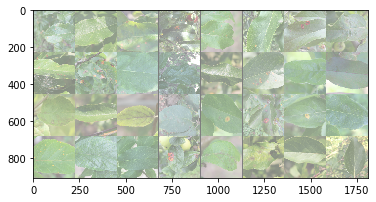

In [34]:
classes = ('healthy', 'multiple_diseases', 'rust', 'scab')

dataiter_test = iter(test_loader)
print('data_iter\n',dataiter_test)
images_test = dataiter_test.next()
images_test_data = images_test[0]
print('image test data',images_test_data)
images_test_label = images_test[1]
print(images_test_label)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# print images
imshow(torchvision.utils.make_grid(images_test_data))
#print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [35]:
model_test = Net()
model_test.load_state_dict(torch.load('model_patho_32_h4.pt'))
model_test = model_test.eval()

outputs_test = model_test(images_test_data)



C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:152: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [36]:
out_fwd = model_test.forward(images_test_data)
print('Result preditcion model on dataset:\n {}\n'.format(out_fwd))
probs = torch.exp(out_fwd)
print('probs\n', probs)
top_probs, top_labs = probs.topk(4)
print('top_probs:\n {} \n top_labs:\n {}'.format(top_probs, top_labs))
print(classes[top_labs[0][0].detach().numpy()])
print(classes[top_labs[1][0].detach().numpy()])
print(classes[top_labs[2][0].detach().numpy()])
print(classes[top_labs[3][0].detach().numpy()])

Result preditcion model on dataset:
 tensor([[-1.8524, -2.3142, -1.2699, -0.7691],
        [-1.9687, -2.4890, -1.2804, -0.6943],
        [-1.8423, -2.2783, -1.2525, -0.7912],
        [-1.5549, -1.9758, -1.2033, -1.0500],
        [-1.9994, -2.5370, -1.3067, -0.6640],
        [-1.9886, -2.5063, -1.3126, -0.6686],
        [-2.1026, -2.6527, -1.3211, -0.6152],
        [-1.8968, -2.4126, -1.3001, -0.7177],
        [-1.6428, -2.0307, -1.1959, -0.9865],
        [-1.5741, -1.9869, -1.1877, -1.0476],
        [-0.8564, -2.4556, -1.2108, -1.6527],
        [-0.3975, -3.6317, -1.4964, -2.5563],
        [-1.7191, -2.1572, -1.2241, -0.8889],
        [-1.5884, -2.0212, -1.2145, -1.0041],
        [-1.0492, -2.1167, -1.1851, -1.4977],
        [-0.6542, -2.7935, -1.2913, -1.9379],
        [-2.1099, -2.6874, -1.3407, -0.5996],
        [-1.6987, -2.1035, -1.2288, -0.9103],
        [-2.1674, -2.7509, -1.3439, -0.5783],
        [-1.5592, -2.0382, -1.2128, -1.0160],
        [-0.6325, -2.8582, -1.3106, -1.9539

C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:152: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [37]:
plok, predicted = torch.max(outputs_test, 1)

print(plok)
print(predicted)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

tensor([-0.7691, -0.6943, -0.7912, -1.0500, -0.6640, -0.6686, -0.6152, -0.7177,
        -0.9865, -1.0476, -0.8564, -0.3975, -0.8889, -1.0041, -1.0492, -0.6542,
        -0.5996, -0.9103, -0.5783, -1.0160, -0.6325, -0.6486, -0.8353, -0.3973,
        -0.8296, -1.0881, -0.2916, -1.0502, -0.7100, -0.6921, -1.1619, -0.9990],
       grad_fn=<MaxBackward0>)
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 0, 0, 3, 3, 3, 3, 0, 3, 3, 0,
        3, 3, 0, 3, 3, 3, 3, 3])
Predicted:   scab  scab  scab  scab


# Submission

In [38]:
submission_df = pd.read_csv(data_dir + 'sample_submission.csv')

submission_df.iloc[:, 1:] = 0

submission_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0,0,0,0
1,Test_1,0,0,0,0
2,Test_2,0,0,0,0
3,Test_3,0,0,0,0
4,Test_4,0,0,0,0


In [39]:
submission_df_test = pd.read_csv(data_dir + 'sample_submission.csv')

model_test = Net()
model_test.load_state_dict(torch.load('model_patho_32_h4.pt'))
model_test = model_test.eval()

batch_size = 4

for data in enumerate(test_loader):
    images_data = data[1][0]
    #print(images_data)
    label_data = data[1][1]
    #print(label_data)   
    probs = torch.exp(model_test(images_data))
    #print(probs)
    label_data = label_data.numpy()
    #print(label_data)
    probs = probs.detach().numpy()
    #print(probs)
    for i in range(len(label_data)):
        #print(i)
        ind = label_data[i]
        #print(ind)
        res_probs = probs[i]
        #print(res_probs)
        res_add = ['Test_'+str(ind), res_probs[0], res_probs[1],res_probs[2],res_probs[3]]
        submission_df_test.loc[ind] = res_add         
        
pd.set_option("display.max_rows", 10, "display.max_columns", None)
print(submission_df_test)
submission_df_test.to_csv(path_or_buf='sample_submission_2.csv', index=False)


C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:152: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


       image_id   healthy  multiple_diseases      rust      scab
0        Test_0  0.184305           0.122021  0.289264  0.404411
1        Test_1  0.199131           0.135076  0.298344  0.367449
2        Test_2  0.138398           0.083177  0.277137  0.501289
3        Test_3  0.398843           0.099541  0.300860  0.200757
4        Test_4  0.244730           0.162892  0.299401  0.292977
...         ...       ...                ...       ...       ...
1816  Test_1816  0.112037           0.061500  0.253023  0.573441
1817  Test_1817  0.169578           0.106310  0.288167  0.435946
1818  Test_1818  0.289738           0.141738  0.304140  0.264385
1819  Test_1819  0.222181           0.138717  0.297705  0.341398
1820  Test_1820  0.226852           0.156780  0.299668  0.316699

[1821 rows x 5 columns]
